In [1]:
! pip install transformers

     |████████████████████████████████| 2.6 MB 9.4 MB/s 
     |████████████████████████████████| 3.3 MB 58.3 MB/s 
     |████████████████████████████████| 895 kB 58.2 MB/s 
     |████████████████████████████████| 636 kB 60.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 17.4 MB 118 kB/s 
     |████████████████████████████████| 1.9 MB 40.8 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [3]:
!pip install wandb -qqq

     |████████████████████████████████| 1.7 MB 8.6 MB/s 
     |████████████████████████████████| 188 kB 60.0 MB/s 
     |████████████████████████████████| 133 kB 69.7 MB/s 
     |████████████████████████████████| 170 kB 68.1 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 


In [4]:
!nvidia-smi

Sat Jul 31 20:19:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from google.colab import files, drive

#W&B accounts - https://wandb.ai/home - tracking machine learning
import wandb

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [6]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [7]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc
path = '/gdrive/My Drive/Colab Notebooks/nlp_tcc'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc


In [8]:
!ls ./amostra_news_integrada/ -lh

total 483M
-rw------- 1 root root  49M Jul 31 20:13 test.csv
-rw------- 1 root root 386M Jul 31 20:13 train.csv
-rw------- 1 root root  49M Jul 31 20:13 valid.csv


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
source_folder = './amostra_news_integrada' #'/content'
destination_folder = '/content'


In [11]:
#Log in W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
#hiper-parâmetros rastreados no weight&biases
#wandb.init(
#    project="pln_news_classifier",
#    #hiper-parâmetros
#    config={
#      'MAX_SEQ_LEN' : 128,  #limita os artigos em 128 tokens. Bert é limitado em 512 tokens por texto (checar isto e aplicar limpeza nos textos).
#      'bs' : 16,  # batch size = 16
#      'qtd_category':39,  #nro de categorias na amostra
#      'bertimbau':'neuralmind/bert-base-portuguese-cased'
#    })
#config = wandb.config


In [12]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hiper-parameter
MAX_SEQ_LEN =  128,  #limita os artigos em 128 tokens. Bert é limitado em 512 tokens por texto (checar isto e aplicar limpeza nos textos).
bs =  16,  # batch size = 16
qtd_category = 39,  #nro de categorias na amostra
bertimbau = 'neuralmind/bert-base-portuguese-cased'


PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token) 
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=config.MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=config.bs, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=config.bs, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=config.bs, device=device, train=False, shuffle=False, sort=False)


wandb: Currently logged in as: hederson (use `wandb login --relogin` to force relogin)


In [ ]:
  wandb.finish()

In [13]:
print(vars(train[0]))
print(vars(valid[0]))
print(vars(test[0]))

{'text': [101, 761, 146, 100, 1247, 229, 10622, 171, 338, 350, 8551, 22287, 125, 511, 174, 171, 2088, 125, 2631, 10922, 117, 229, 3787, 117, 146, 1910, 5789, 5754, 11596, 3660, 6151, 118, 14258, 113, 1934, 114, 327, 5926, 229, 2310, 221, 259, 3956, 6955, 171, 1007, 125, 1455, 119, 2067, 180, 5926, 15669, 117, 5754, 117, 179, 2286, 123, 4428, 11838, 22307, 117, 1934, 2038, 117, 346, 12900, 353, 2171, 774, 180, 3109, 118, 820, 259, 1242, 1867, 8978, 176, 15709, 228, 119, 231, 1910, 262, 12439, 243, 170, 123, 5926, 229, 1007, 118, 4284, 2113, 146, 13355, 8905, 178, 19734, 117, 179, 770, 5491, 5926, 423, 2453, 298, 3956, 4782, 118, 13421, 22281, 125, 11719, 117, 122, 146, 3065, 21077, 16180, 7832, 735, 117, 5905, 171, 2236, 9920, 117, 5157, 420, 259, 1242, 1867, 119, 107, 3396, 346, 15212, 2798, 3724, 221, 4640, 119, 9009, 203, 785, 117, 785, 8540, 119, 1643, 2779, 770, 8544, 13685, 1950, 4029, 2646, 170, 146, 2453, 117, 240, 370, 1858, 576, 179, 6331, 230, 2341, 567, 117, 179, 253, 230, 2

## Modelo

In [21]:
'''É preciso informar o número de labels, pois o BERTimbau foi treinado para 2 classes '''
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained(config.bertimbau,num_labels=config.qtd_category )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [22]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [23]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [18]:
device

device(type='cuda', index=0)

In [24]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

KeyboardInterrupt: ignored

Model loaded from <== /content/metrics.pt


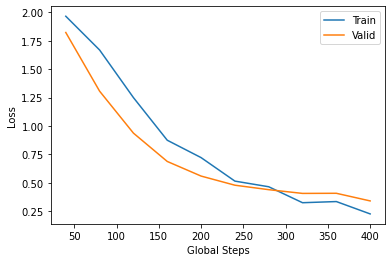

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Avaliação

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== /content/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.9565    0.9565    0.9565        23
           1     0.7857    1.0000    0.8800        22
           2     0.8636    0.8636    0.8636        22
           3     1.0000    1.0000    1.0000        14
           4     0.7619    0.8889    0.8205        18
           5     1.0000    1.0000    1.0000        15
           6     0.9231    0.7059    0.8000        17
           7     0.8750    0.7241    0.7925        29

    accuracy                         0.8812       160
   macro avg     0.8957    0.8924    0.8891       160
weighted avg     0.8879    0.8812    0.8794       160



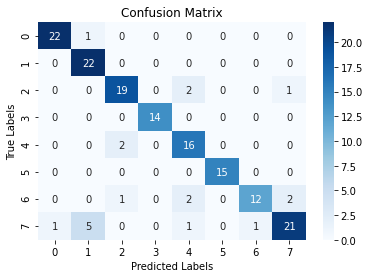

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1
    print(classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)


## Salvando o modelo

In [ ]:
from google.colab import files, drive
from pathlib import Path
import pickle
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc
path = '/gdrive/My Drive/Colab Notebooks/nlp_tcc'
arquivo = '/bertimbau_classifier_pt'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc


In [ ]:
pickle.dump(best_model, open(path+arquivo,'wb'))
pickle.dump(tokenizer, open(path+arquivo+'_token','wb'))

## Aplicando o modelo nas miscelâneas de notícias

In [ ]:
#carregando o modelo e o tokenizador
model = pickle.load(open(path+arquivo,'rb'))
token = pickle.load(open(path+arquivo+'_token','rb'))

### Tokenizando

In [ ]:
# TabularDataset
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field)]

miscelanea = TabularDataset.splits(path=source_folder, miscelanea='miscelanea.csv', 
                                  format='CSV',fields=fields, skip_header=True)

# Iterators

miscelanea_iter = BucketIterator(miscelanea, batch_size=bs, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)

In [ ]:
tokenizer("Hoje é um belo dia de sábado, porém estou aqui estudando.")

{'input_ids': [101, 6029, 253, 222, 15152, 644, 125, 14157, 117, 1804, 12044, 5863, 19679, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}